## Exploring New York City Marathon Data



In [19]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [6]:
nyc_data = pd.read_csv('NYCMresults_2008.csv', header=None)
nyc_data.head()

,0,1,2,3,4,5
0,MARILSON,GOMES DOS SANTOS,31,M,1:06:07,2:08:43
1,ABDERRAHIM,GOUMRI,32,M,1:06:06,2:09:07
2,DANIEL,RONO,30,M,1:06:06,2:11:22
3,PAUL,TERGAT,39,M,1:06:06,2:13:10
4,ABDERRAHIME,BOURAMDANE,30,M,1:06:06,2:13:33


In [8]:
!pip install datetime

You should consider upgrading via the 'd:\diploma\winter 20\data analytics\project\myenv\scripts\python.exe -m pip install --upgrade pip' command.


In [12]:
import datetime
def convert_time(s):
    h, m, s = map(int, s.split(':'))
    return datetime.timedelta(hours=h, minutes=m, seconds=s)

nyc_data = pd.read_csv('NYCMresults_2008.csv',
                       names=['first', 'last', 'age', 'gender', 'split', 'final'],
                       converters={'split':convert_time, 'final':convert_time})

In [13]:
nyc_data.head()

,first,last,age,gender,split,final
0,MARILSON,GOMES DOS SANTOS,31,M,01:06:07,02:08:43
1,ABDERRAHIM,GOUMRI,32,M,01:06:06,02:09:07
2,DANIEL,RONO,30,M,01:06:06,02:11:22
3,PAUL,TERGAT,39,M,01:06:06,02:13:10
4,ABDERRAHIME,BOURAMDANE,30,M,01:06:06,02:13:33


In [16]:
nyc_data['split_sec'] = nyc_data['split']/np.timedelta64(1,'s')
nyc_data['final_sec'] = nyc_data['final'].astype('<i8') / 1E9

In [17]:
nyc_data.head()

,first,last,age,gender,split,final,split_sec,final_sec
0,MARILSON,GOMES DOS SANTOS,31,M,01:06:07,02:08:43,3967.0,7723.0
1,ABDERRAHIM,GOUMRI,32,M,01:06:06,02:09:07,3966.0,7747.0
2,DANIEL,RONO,30,M,01:06:06,02:11:22,3966.0,7882.0
3,PAUL,TERGAT,39,M,01:06:06,02:13:10,3966.0,7990.0
4,ABDERRAHIME,BOURAMDANE,30,M,01:06:06,02:13:33,3966.0,8013.0


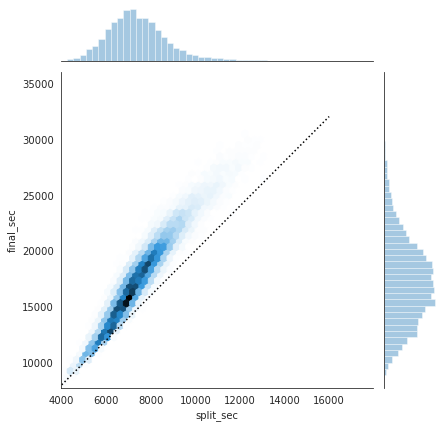

In [20]:
with sns.axes_style('white'):
    g = sns.jointplot("split_sec", "final_sec", nyc_data, kind='hex', stat_func=None)
    g.ax_joint.plot(np.linspace(4000, 16000),
                    np.linspace(8000, 32000), ':k')

The dotted line shows where someone's time would lie if they ran the marathon at a perfectly steady pace. The fact that the distribution lies above this indicates (as you might expect) that most people slow down over the course of the marathon.

Let's create another column in the data, the split fraction, which tells whether someone did a negative split or positive split:

In [21]:
nyc_data['split_frac'] = 1 - 2 * nyc_data['split_sec'] / nyc_data['final_sec']
nyc_data.head()

,first,last,age,gender,split,final,split_sec,final_sec,split_frac
0,MARILSON,GOMES DOS SANTOS,31,M,01:06:07,02:08:43,3967.0,7723.0,-0.027321
1,ABDERRAHIM,GOUMRI,32,M,01:06:06,02:09:07,3966.0,7747.0,-0.023880
2,DANIEL,RONO,30,M,01:06:06,02:11:22,3966.0,7882.0,-0.006344
3,PAUL,TERGAT,39,M,01:06:06,02:13:10,3966.0,7990.0,0.007259
4,ABDERRAHIME,BOURAMDANE,30,M,01:06:06,02:13:33,3966.0,8013.0,0.010109


Where this split difference is less than zero, the person negative-split the race by that fraction.
Let's do a distribution plot of this split fraction:

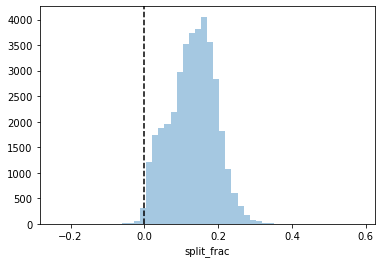

In [22]:
sns.distplot(nyc_data['split_frac'], kde=False);
plt.axvline(0, color="k", linestyle="--");

In [23]:
sum(nyc_data.split_frac < 0)

240

There were 240 people who negative-split their race.

Let's see whether there is any correlation between this split fraction and other variables. We'll do this using a `PairGrid`:

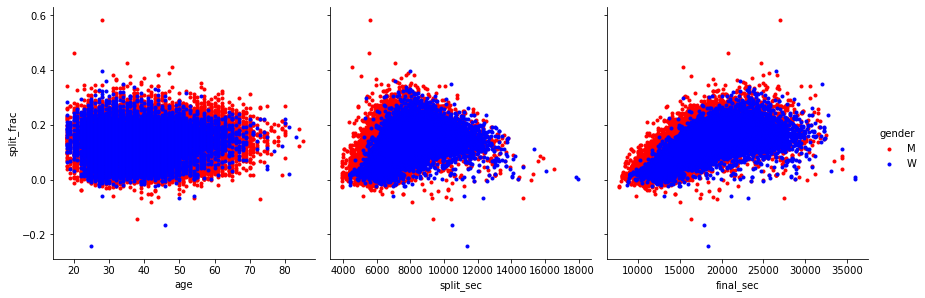

In [25]:
g = sns.PairGrid(nyc_data,
                 x_vars=['age', 'split_sec', 'final_sec'],
                 y_vars=['split_frac'],
                 hue='gender', palette=['r', 'b'], height=4)
g.map(plt.scatter, marker='.')
g.add_legend();

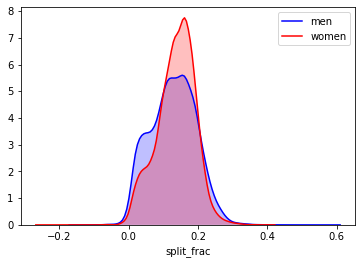

In [26]:
sns.kdeplot(nyc_data.split_frac[nyc_data.gender=='M'], label='men', color='b', shade=True)
sns.kdeplot(nyc_data.split_frac[nyc_data.gender=='W'], label='women', color='r', shade=True)
plt.xlabel('split_frac');

The interesting thing here is that there are many more men than women who are running close to an even split!
This almost looks like some kind of bimodal distribution among the men and women. Let's see if we can suss-out what's going on by looking at the distributions as a function of age.

A nice way to compare distributions is to use a *Violin Plot*

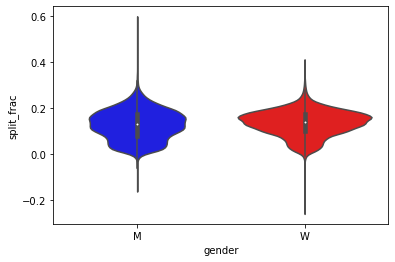

In [27]:
# def age_range(age_min, age_max):
#    return (nyc_data.age >= age_min) & (nyc_data.age < age_max)

sns.violinplot("gender", "split_frac", data=nyc_data, palette=["b", "r"]);

This is yet another way to view the distributions among men and women.

Let's look a little deeper, and compare these violin plots as a function of age. We'll start by creating a new column in the array which specifies the decade of age that each person is in:

In [28]:
nyc_data['age_dec'] = nyc_data.age.map(lambda age: 10 * (age // 10))
nyc_data.head()

,first,last,age,gender,split,final,split_sec,final_sec,split_frac,age_dec
0,MARILSON,GOMES DOS SANTOS,31,M,01:06:07,02:08:43,3967.0,7723.0,-0.027321,30
1,ABDERRAHIM,GOUMRI,32,M,01:06:06,02:09:07,3966.0,7747.0,-0.023880,30
2,DANIEL,RONO,30,M,01:06:06,02:11:22,3966.0,7882.0,-0.006344,30
3,PAUL,TERGAT,39,M,01:06:06,02:13:10,3966.0,7990.0,0.007259,30
4,ABDERRAHIME,BOURAMDANE,30,M,01:06:06,02:13:33,3966.0,8013.0,0.010109,30


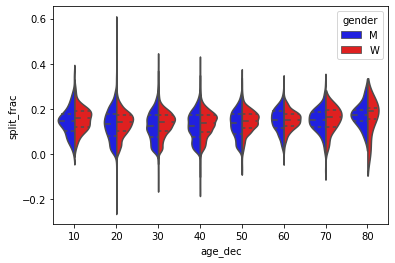

In [29]:
sns.violinplot("age_dec", "split_frac", hue="gender", data=nyc_data,
               split=True, inner="quartile", palette=["b", "r"]);

Looking at this, we can see where the distributions of men and women differ: the split distributions of men in their 20s-50s show a pronounced over-density toward lower splits when compared to women of the same age (or of any age, for that matter).

Also surprisingly, the 80-year-old women seem to out-perform *everyone* in terms of their split time. I'm not sure how to explain that.

Back to the men with fast second-halfs: who are these runners? Does this split fraction correlate with finishing quickly? We can plot this very easily. We'll use ``lmplot``, which will automatically fit a linear regression to the data:

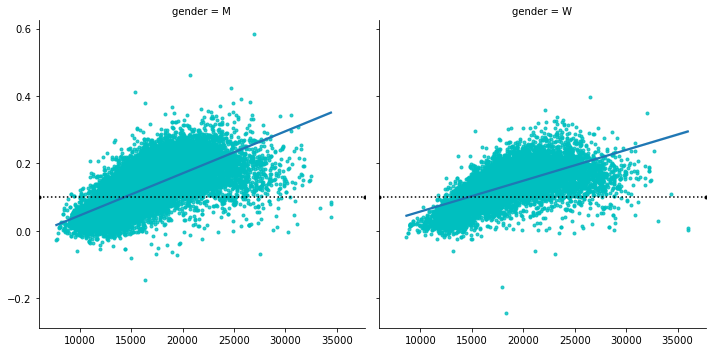

In [30]:
g = sns.lmplot('final_sec', 'split_frac', col='gender', data=nyc_data,
               markers=".", scatter_kws=dict(color='c'))
g.map(plt.axhline, y=0.1, color="k", ls=":");

Apparently the people with fast splits are the elite runners who are finishing within ~15000 sec, or about 4 hours. People slower than that are much less likely to have a fast second split.

I would hypothesize that you could describe the distribution of runners with a two-component Gaussian distribution: there are the *elite* runners who are in shape and have fast splits, and there are the *casual* runners who are less in shape and tend to tire out more. 

### Hospital Visits Data
#### Does the new law have any effect on the hospital visits?


In [31]:
# Start with our normal batch of imports and settings
from __future__ import print_function, division

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns; sns.set()

## 1. Load the Data

1. Load the files:
   - maleVisitsToPhysician.csv
   - femaleVisitsToPhysician.csv
2. load females and males data separately (try setting the ``index_col`` argument to set the index to the first column)
3. combine using ``pd.concat`` into a single dataframe

In [32]:
females = pd.read_csv('femaleVisitsToPhysician.csv')
females.head()

,Unnamed: 0,year,age,sex,consultations,population,perCapita
0,4,2006,1,f,67194.0,28221.0,2.380993
1,7,2006,2,f,49802.0,28361.0,1.756003
2,10,2006,3,f,42741.0,27899.0,1.531990
3,13,2006,4,f,36555.0,28420.0,1.286242
4,16,2006,5,f,33319.0,29479.0,1.130262


It looks like this unnamed column is meant to be some sort of index. Let's use it as a numerical index for the data:

In [33]:
females = pd.read_csv('femaleVisitsToPhysician.csv',
                      index_col=0)
females.head()

,year,age,sex,consultations,population,perCapita
4,2006,1,f,67194.0,28221.0,2.380993
7,2006,2,f,49802.0,28361.0,1.756003
10,2006,3,f,42741.0,27899.0,1.531990
13,2006,4,f,36555.0,28420.0,1.286242
16,2006,5,f,33319.0,29479.0,1.130262


Now we do the same for the males data:

In [34]:
males = pd.read_csv('maleVisitsToPhysician.csv',
                    index_col=0)
males.head()

,year,age,sex,consultations,population,perCapita
5,2006,1,m,78700.0,29535.0,2.664635
8,2006,2,m,57272.0,29504.0,1.941161
11,2006,3,m,47374.0,28894.0,1.639579
14,2006,4,m,39366.0,29576.0,1.331012
17,2006,5,m,36272.0,30953.0,1.171841


Concatenating these together, we get the following:

In [35]:
data = pd.concat([males, females]).sort_index()
data.head()

,year,age,sex,consultations,population,perCapita
4,2006,1,f,67194.0,28221.0,2.380993
5,2006,1,m,78700.0,29535.0,2.664635
7,2006,2,f,49802.0,28361.0,1.756003
8,2006,2,m,57272.0,29504.0,1.941161
10,2006,3,f,42741.0,27899.0,1.531990


## 2. Visualize the data

For each gender, the data shows the per capita consultations by age and year.
Use ``pd.pivot_table`` and plot the data.

Also, as you create these plots, experiment with ``sns.set_palette`` to get a color scheme which helps convey the information you're interested in.

1. Use a pivot table to index the data by age and gender
2. Plot age vs per capita visits for females, one line per year
3. Plot age vs per capita visits for males, one line per year

In [36]:
by_age = data.pivot_table('perCapita', index=['sex', 'age'], columns='year')
by_age.head()

year         2006      2007      2008      2009      2010      2011      2012  \
sex age                                                                         
f   1    2.380993  2.349824  2.425987  2.419597  2.630705  2.483097  2.482780   
    2    1.756003  1.720274  1.776511  1.689157  1.783554  1.758548  1.807354   
    3    1.531990  1.479736  1.441581  1.455040  1.405735  1.465799  1.469925   
    4    1.286242  1.255660  1.242319  1.231516  1.229607  1.266953  1.272097   
    5    1.130262  1.101836  1.128775  1.111600  1.062639  1.183401  1.134739   

year         2013  
sex age            
f   1    2.367074  
    2    1.655557  
    3    1.367749  
    4    1.184196  
    5    1.091244

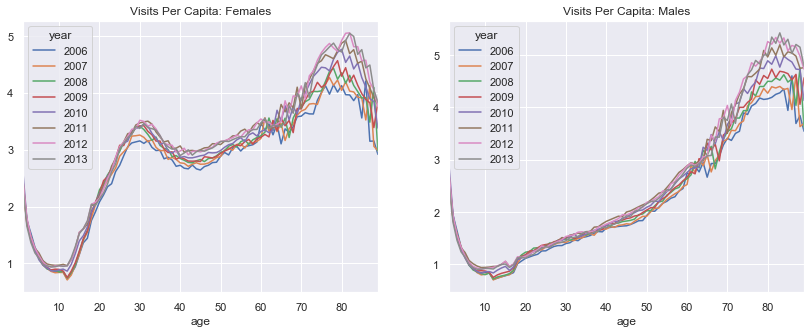

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_age.loc['f'].plot(ax=ax[0], title='Visits Per Capita: Females')
by_age.loc['m'].plot(ax=ax[1], title='Visits Per Capita: Males');

Because the color palette is not sequential, some of the trend is hidden. Let's choose an 8-step sequential palette that will show us more information:

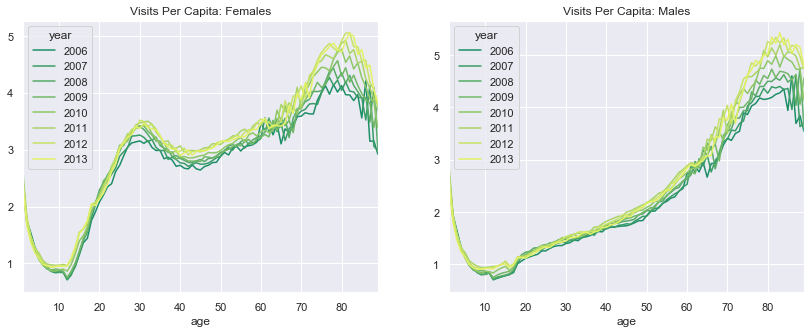

In [38]:
sns.set_palette('summer', 8)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_age.loc['f'].plot(ax=ax[0], title='Visits Per Capita: Females')
by_age.loc['m'].plot(ax=ax[1], title='Visits Per Capita: Males');

Now we can see that there seems to be an overall upward trend in visits.

## 3. Effect of the Medicare 2010 Copayment Elimination

The copayment for doctor's visits was eliminated in 2010. Let's see whether there is any indication that this affected the rate of visits

1. Add a column to the data called ``with_copay``, which is True if the year is prior to 2010, and False otherwise
2. Use a pivot table to plot the mean visits per capita for the years with a copay and without (one plot each for men and women)
3. Plot the percentage increase in per capita visits as a function of age. What age ranges did the copay change most affect?

In [39]:
data['with_copay'] = (data['year'] < 2010)
data.head()

,year,age,sex,consultations,population,perCapita,with_copay
4,2006,1,f,67194.0,28221.0,2.380993,True
5,2006,1,m,78700.0,29535.0,2.664635,True
7,2006,2,f,49802.0,28361.0,1.756003,True
8,2006,2,m,57272.0,29504.0,1.941161,True
10,2006,3,f,42741.0,27899.0,1.531990,True


In [40]:
by_age_copay = data.pivot_table('perCapita', index=['sex', 'age'],
                                columns='with_copay', aggfunc='mean')
by_age_copay.head()

with_copay     False     True 
sex age                       
f   1       2.490914  2.394100
    2       1.751253  1.735486
    3       1.427302  1.477087
    4       1.238213  1.253934
    5       1.118006  1.118118

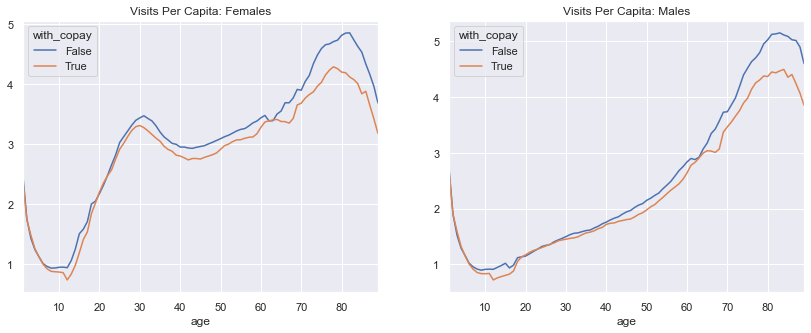

In [41]:
sns.set() # reset palette

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_age_copay.loc['f'].plot(ax=ax[0], title='Visits Per Capita: Females')
by_age_copay.loc['m'].plot(ax=ax[1], title='Visits Per Capita: Males');

Apparently the removal of the copayment increased the number of visits in much of the population.

Let's look at this percentage directly:

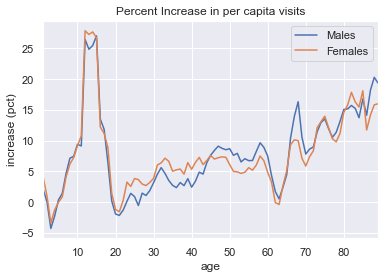

In [42]:
increase = 100 * (by_age_copay[False] / by_age_copay[True] - 1)

increase.loc['m'].plot(label='Males')
increase.loc['f'].plot(label='Females')
plt.legend();
plt.ylabel('increase (pct)')
plt.title('Percent Increase in per capita visits');

Here we see an interesting trend: the lack of copay increased visits by teenagers more than any other group!

In [43]:
!jupyter nbconvert --to html Data_Analysis_Project.ipynb

[NbConvertApp] Converting notebook Data_Analysis_Project.ipynb to html
[NbConvertApp] Writing 875474 bytes to Data_Analysis_Project.html
